The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_temp/convergence_analysis2/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


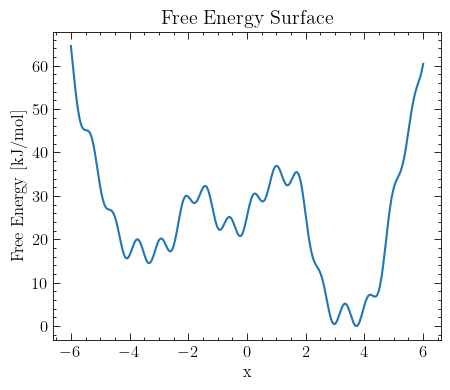

In [9]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis2/"): print("\nThe data folder \"_data_temp/convergence_analysis2/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis2/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis2/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 4
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

#### Define default parameters

In [12]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [52]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, "dy":dy, # "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 1_000_000, 
					"position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
                    "len_error_list":100, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True,
     				"simulation_folder_path": path_data, "print_info": False}

### Run Long simulation for reference

Time taken for Long simulation: 13.0026 sec
Final Error: Aofe=1.5488 AAD=0.4080


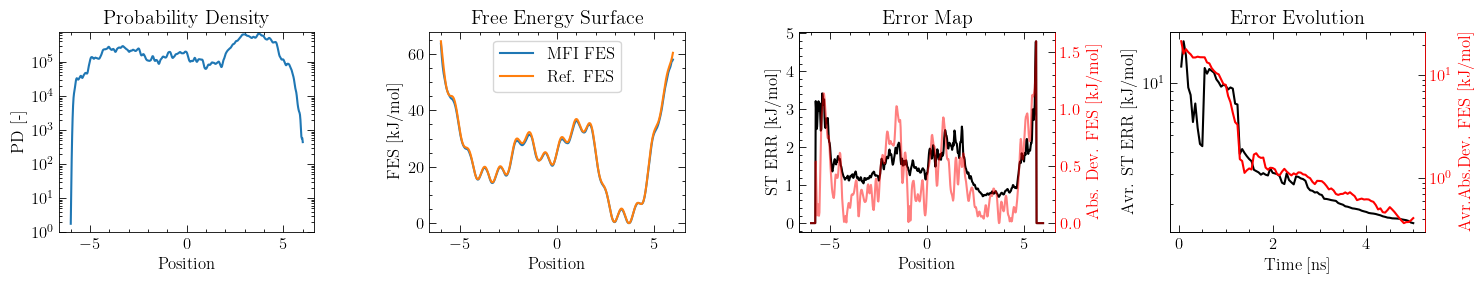

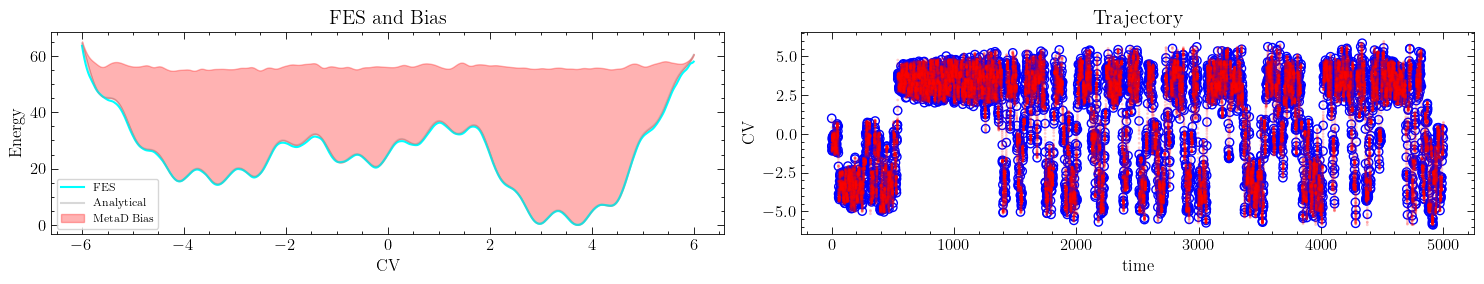

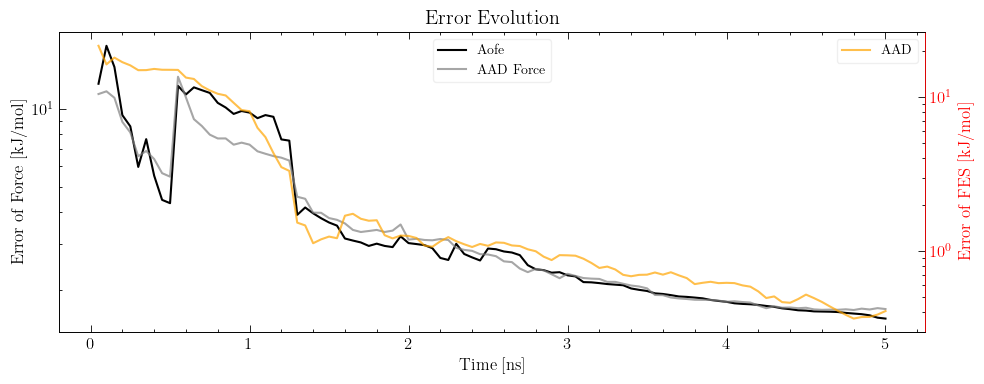

In [60]:
new_params = {**default_params}
new_params.update({"ID":"_long", "metad_height":1, "metad_width":0.1, "biasfactor":20})
new_params.update({"simulation_steps": 1_000_000, "len_error_list":100}) # })# 

## Load MFI object
start = time.time()
MFI_long = MFI_class1D.MFI1D(**new_params)

## Run the simulation
MFI_long.run_simulation()

## Analyse the data
MFI_long.analyse_data()

print(f"Time taken for Long simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_long.Aofe:.4f} AAD={MFI_long.AAD:.4f}")

## Plot the results and save the data for later use
MFI_long.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_long.grid, fes=MFI_long.FES, metad_bias=MFI_long.Bias, position=MFI_long.position, hills=MFI_long.hills, y=MFI_long.y )
MFI_long.plot_errors()

t_long, aofe_long, aad_long = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:,MFI_long.aad_index]


### Exploration simulation

Time taken for Expl. simulation: 1.3669 sec
Final Error: Aofe=4.9612 AAD=1.5598


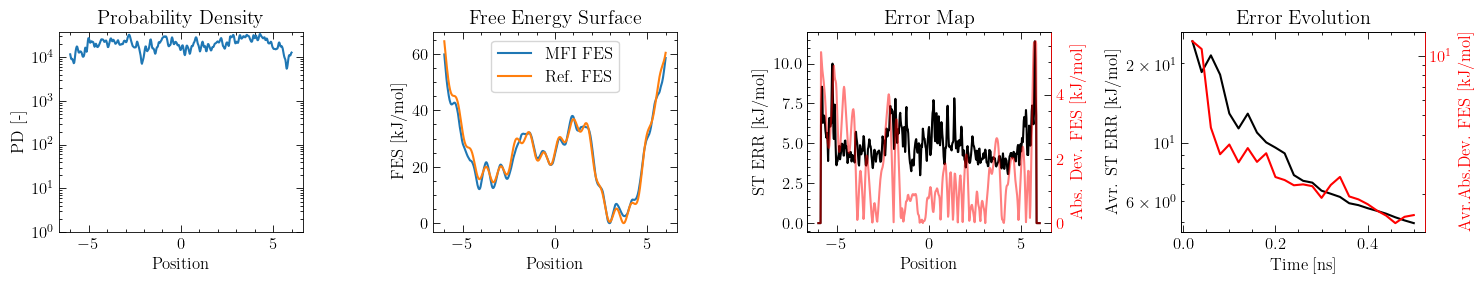

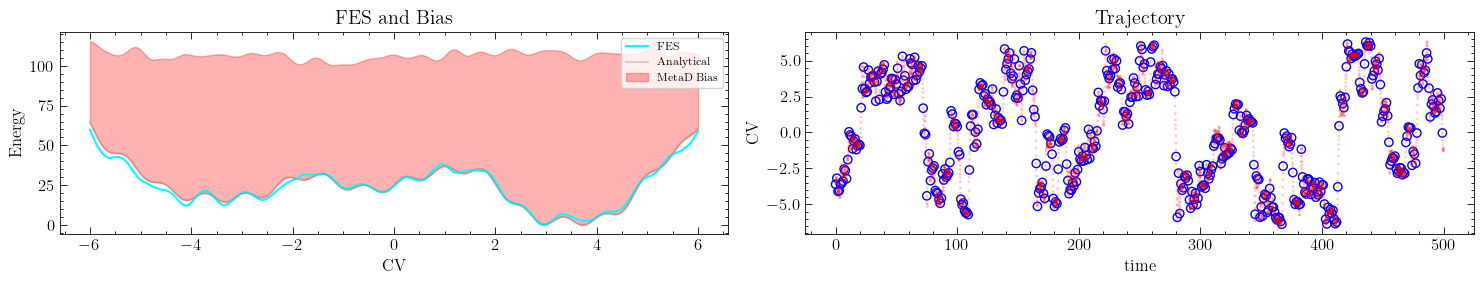

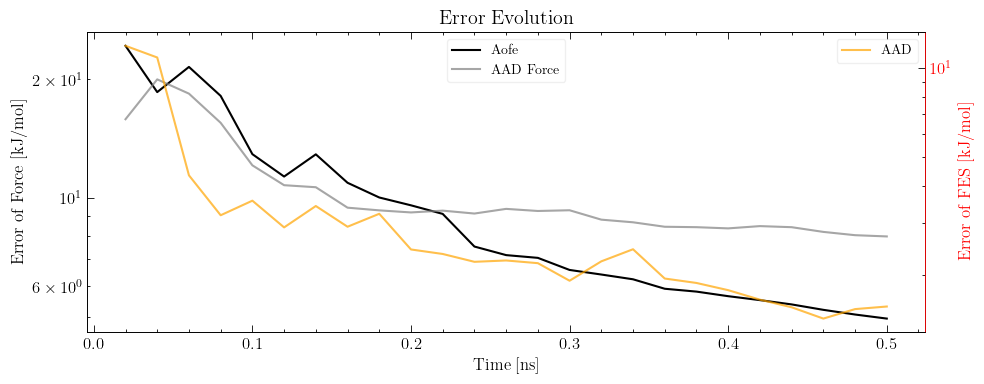

In [64]:
new_params = {**default_params}
new_params.update({"ID":"_expl", "metad_height":5, "metad_width":0.2, "biasfactor":200})
new_params.update({"simulation_steps": 100_000, "len_error_list":25}) #  })#

## Load MFI object
start = time.time()
MFI_expl = MFI_class1D.MFI1D(**new_params)

## Run the simulation
MFI_expl.run_simulation()

## Analyse the data
MFI_expl.analyse_data()

print(f"Time taken for Expl. simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_expl.Aofe:.4f} AAD={MFI_expl.AAD:.4f}")

## Plot the results and save the data for later use
MFI_expl.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_expl.grid, fes=MFI_expl.FES, metad_bias=MFI_expl.Bias, position=MFI_expl.position, hills=MFI_expl.hills, y=MFI_expl.y )
MFI_expl.plot_errors()

t_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:,MFI_expl.aad_index]
# base_force_expl, base_forces_e_list_expl, fes_expl = MFI_expl.force_terms, MFI_expl.forces_e_list, MFI_expl.FES


### 2nd Stage - Run MetaD simulation

Time taken for MetaD simulation: 4.1403 sec
Final Error: Aofe=1.5298 AAD=0.1487


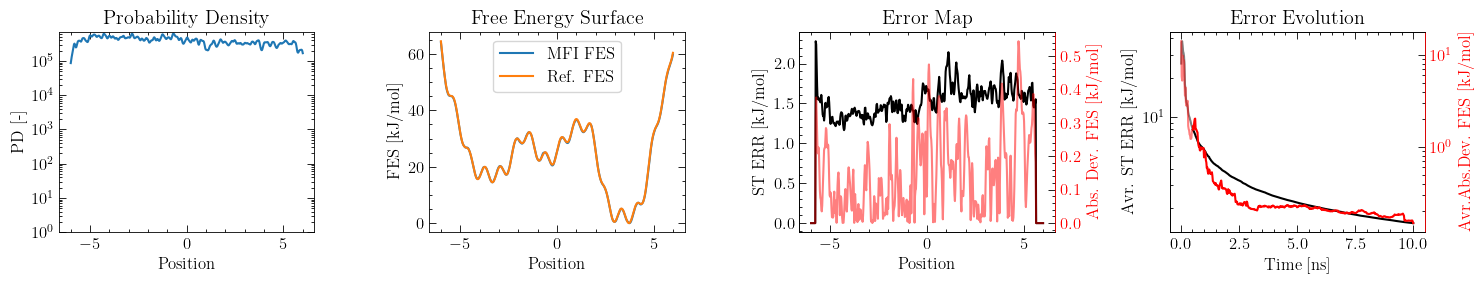

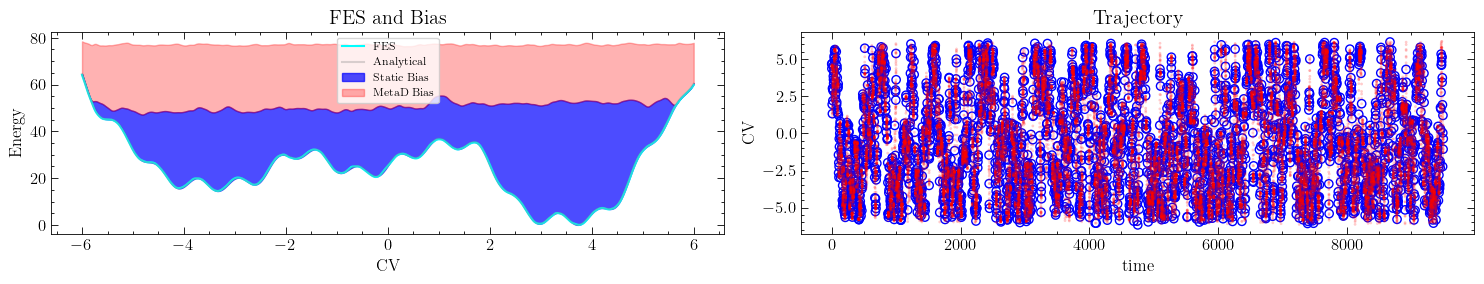

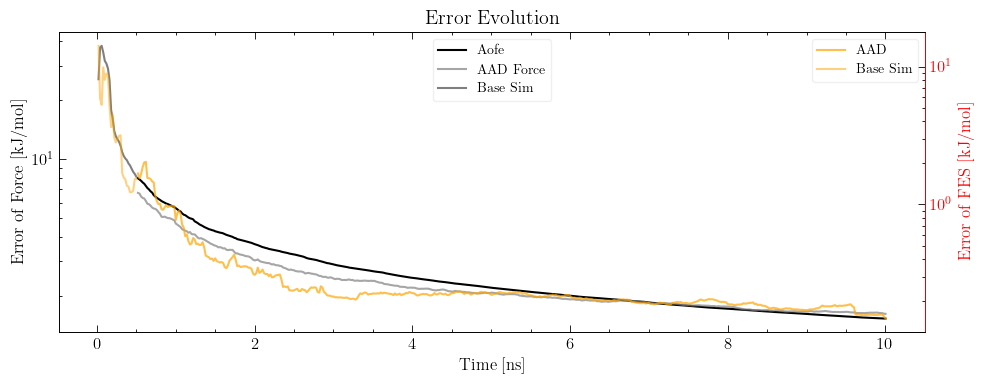

In [5]:
new_params = {**default_params}
new_params.update({"ID":"_metad", "metad_height":2, "biasfactor":10})
new_params.update({"simulation_steps": 1_900_000, "len_error_list":475})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":MFI_expl.forces_e_list})


## Load MFI object
start = time.time()
MFI_metad = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI_metad.make_external_bias(MFI_expl.FES)

## Run the simulation
# MFI_metad.run_simulation()

## Analyse the data
MFI_metad.analyse_data()

print(f"Time taken for MetaD simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_metad.Aofe:.4f} AAD={MFI_metad.AAD:.4f}")

## Plot the results and save the data for later use
t_metad, aofe_metad, aad_metad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:,MFI_metad.aad_index]
t12, aofe12, aad12 = np.concatenate((t_expl, t_metad)), np.concatenate((aofe_expl, aofe_metad)), np.concatenate((aad_expl, aad_metad))

MFI_metad.plot_results(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
lib1.plot_FES_Bias_and_Traj(grid=MFI_metad.grid, fes=MFI_metad.FES, metad_bias=MFI_metad.Bias, static_bias=MFI_metad.Bias_static, position=MFI_metad.position, hills=MFI_metad.hills, y=MFI_metad.y )
MFI_metad.plot_errors(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])


### 2nd Stage - Run 2x MetaD simulations

Time taken for x2 MetaD simulation: 4.9613 sec
Final Error: Aofe=1.2069 AAD=0.1267


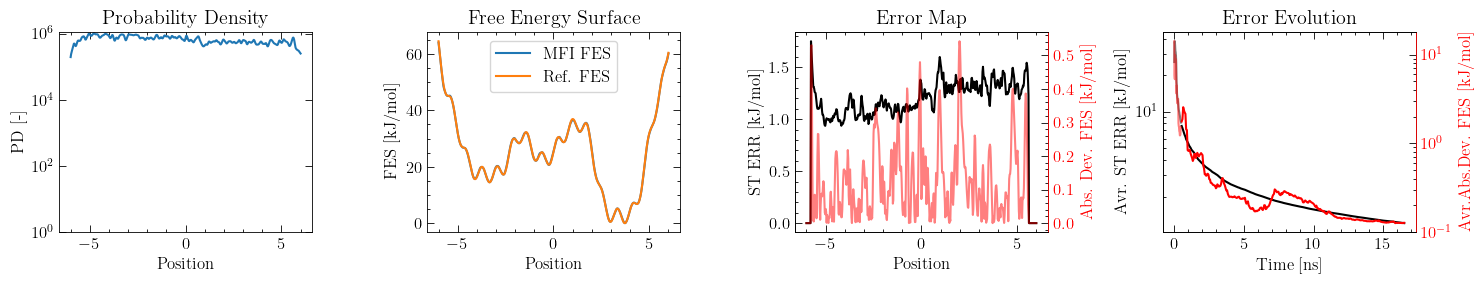

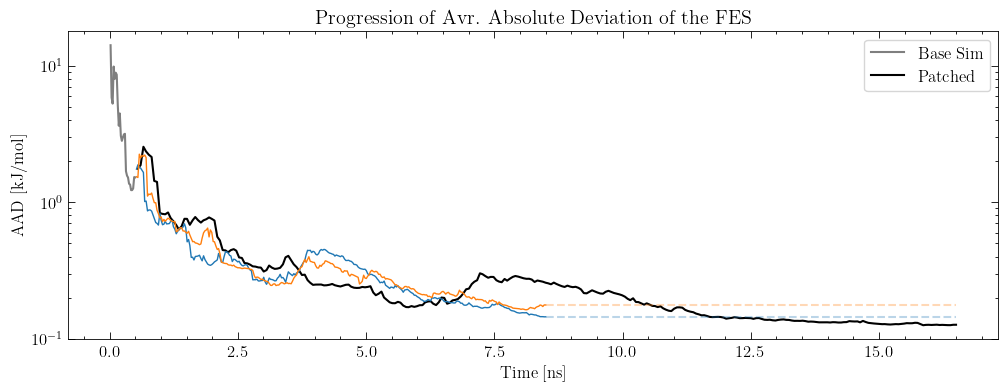

In [106]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x2", "metad_height":3, "biasfactor":10})
new_params.update({"simulation_steps": 1_600_000, "len_error_list":300})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":MFI_expl.forces_e_list})

## Load MFI object
start = time.time()
MFI_metad_x2 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI_metad_x2.make_external_bias(MFI_expl.FES)

## create MFI parallel object
mfi_parallel_x2 = MFI_metad_x2.MFI_parallel(parent=MFI_metad_x2, workers=2)

# # Run the simulation
# mfi_parallel_x2.run_parallel_sim()

# ## Analyse the data
mfi_parallel_x2.analyse_parallel()

start2 = time.time()
mfi_parallel_x2.patch_simulations()

print(f"Time taken for x2 MetaD simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_metad_x2.Aofe:.4f} AAD={MFI_metad_x2.AAD:.4f}")

## Plot the results and save the data for later use
t_x2, aofe_x2, aad_x2 = MFI_metad_x2.Avr_Error_list[:,0], MFI_metad_x2.Avr_Error_list[:,2], MFI_metad_x2.Avr_Error_list[:,MFI_metad_x2.aad_index]
t1x2, aofe1x2, aad1x2 = np.concatenate((t_expl, t_x2)), np.concatenate((aofe_expl, aofe_x2)), np.concatenate((aad_expl, aad_x2))

MFI_metad_x2.plot_results(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
mfi_parallel_x2.plot_parallel_error_progression(error_type=["AAD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])


### 2nd Stage - Run 3x MetaD simulations

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1);

Time taken for x3 MetaD simulation: 3.5237 sec
Final Error: Aofe=1.0287 AAD=0.1589


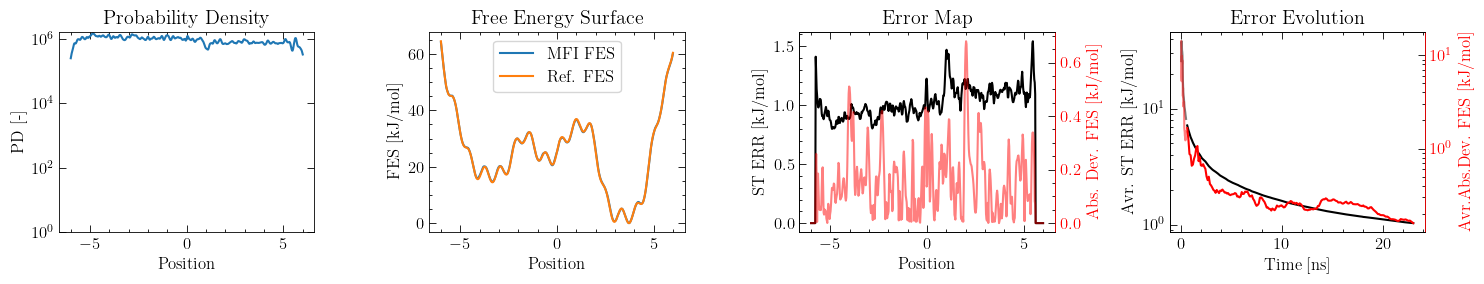

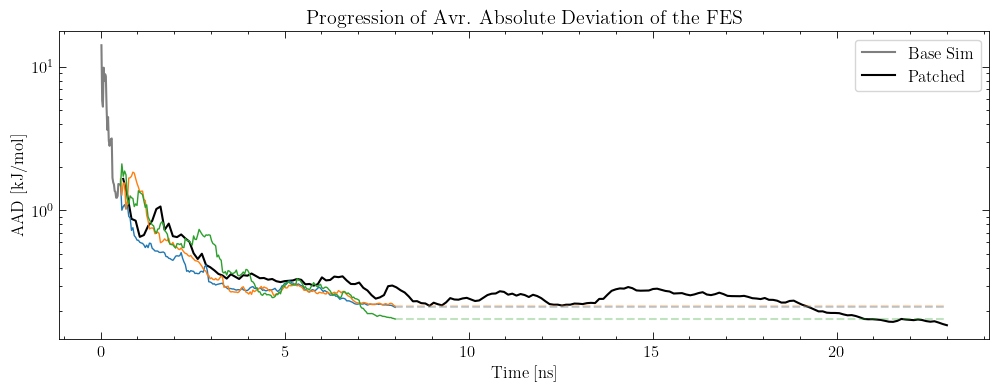

In [105]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x3", "metad_height":3, "biasfactor":10})
new_params.update({"simulation_steps": 1_500_000, "len_error_list":200})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":MFI_expl.forces_e_list})

## Load MFI object
start = time.time()
MFI_metad_x3 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI_metad_x3.make_external_bias(MFI_expl.FES)

## create MFI parallel object
mfi_parallel_x3 = MFI_metad_x3.MFI_parallel(parent=MFI_metad_x3, workers=3)

# # Run the simulation
# mfi_parallel_x3.run_parallel_sim()

# ## Analyse the data
mfi_parallel_x3.analyse_parallel()

start2 = time.time()
mfi_parallel_x3.patch_simulations()

print(f"Time taken for x3 MetaD simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_metad_x3.Aofe:.4f} AAD={MFI_metad_x3.AAD:.4f}")

## Plot the results and save the data for later use
t_x3, aofe_x3, aad_x3 = MFI_metad_x3.Avr_Error_list[:,0], MFI_metad_x3.Avr_Error_list[:,2], MFI_metad_x3.Avr_Error_list[:,MFI_metad_x3.aad_index]
t1x3, aofe1x3, aad1x3 = np.concatenate((t_expl, t_x3)), np.concatenate((aofe_expl, aofe_x3)), np.concatenate((aad_expl, aad_x3))

MFI_metad_x3.plot_results(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
mfi_parallel_x3.plot_parallel_error_progression(error_type=["AAD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])


### 2nd Stage - Run 4x MetaD simulations

Time taken for x4 MetaD simulation: 3.1549 sec
Final Error: Aofe=0.9172 AAD=0.1602


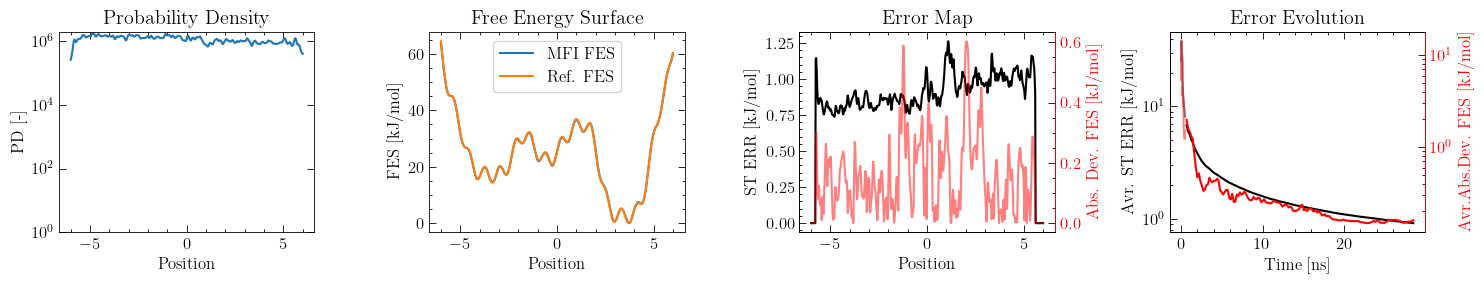

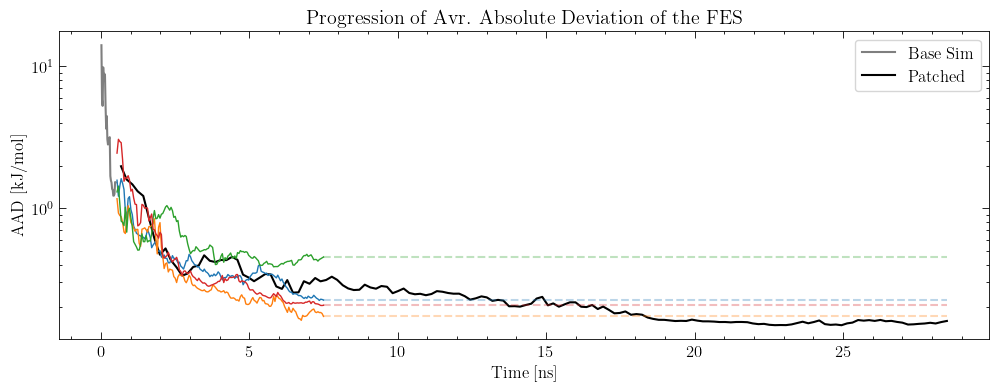

In [110]:
new_params = {**default_params}
new_params.update({"ID":"_metad_x4", "metad_height":3, "biasfactor":10})
new_params.update({"simulation_steps": 1_400_000, "len_error_list":150})
new_params.update({"base_forces":MFI_expl.force_terms, "base_time":MFI_expl.sim_time})#, "base_forces_e_list":MFI_expl.forces_e_list})

## Load MFI object
start = time.time()
MFI_metad_x4 = MFI_class1D.MFI1D(**new_params)

## Make the external bias
MFI_metad_x4.make_external_bias(MFI_expl.FES)

## create MFI parallel object
mfi_parallel_x4 = MFI_metad_x4.MFI_parallel(parent=MFI_metad_x4, workers=4)

# # Run the simulation
# mfi_parallel_x4.run_parallel_sim()

# ## Analyse the data
mfi_parallel_x4.analyse_parallel()

start2 = time.time()
mfi_parallel_x4.patch_simulations()

print(f"Time taken for x4 MetaD simulation: {time.time() - start:.4f} sec")
print(f"Final Error: Aofe={MFI_metad_x4.Aofe:.4f} AAD={MFI_metad_x4.AAD:.4f}")

## Plot the results and save the data for later use
t_x4, aofe_x4, aad_x4 = MFI_metad_x4.Avr_Error_list[:,0], MFI_metad_x4.Avr_Error_list[:,2], MFI_metad_x4.Avr_Error_list[:,MFI_metad_x4.aad_index]
t1x4, aofe1x4, aad1x4 = np.concatenate((t_expl, t_x4)), np.concatenate((aofe_expl, aofe_x4)), np.concatenate((aad_expl, aad_x4))

MFI_metad_x4.plot_results(more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])
mfi_parallel_x4.plot_parallel_error_progression(error_type=["AAD"], more_aofe=[t_expl, aofe_expl] , more_aad = [t_expl, aad_expl])


### Compare Convergence of Simulations

In [2]:
a = ["a", "b"]

print(len(a))

if 1==1: a.remove("a")

print(len(a))
print(a)

2
1
['b']


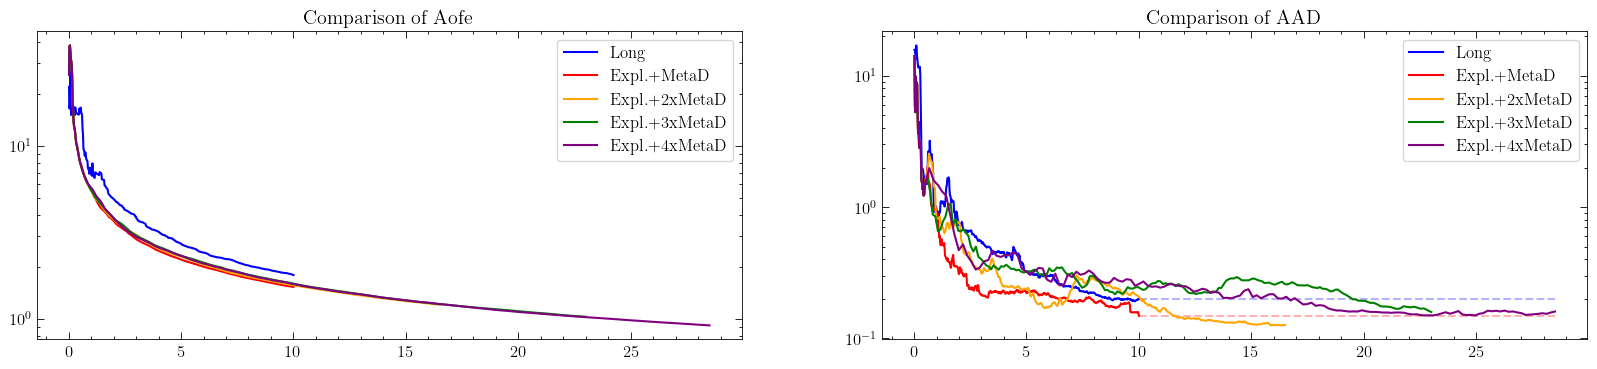

In [111]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.plot(t_long, aofe_long, label="Long", color="blue")
plt.plot(t12, aofe12, label="Expl.+MetaD", color="red")
plt.plot(t1x2, aofe1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aofe1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aofe1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(t_long, aad_long, label="Long", color="blue"); plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t12, aad12, label="Expl.+MetaD", color="red"); plt.plot([t12[-1],t1x4[-1]], [aad12[-1],aad12[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(t1x2, aad1x2, label="Expl.+2xMetaD", color="orange")
plt.plot(t1x3, aad1x3, label="Expl.+3xMetaD", color="green")
plt.plot(t1x4, aad1x4, label="Expl.+4xMetaD", color="purple")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
